In [39]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [2]:
import pandas as pd

#lectura del df
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
#Mini EDA

In [4]:
df.shape

(145460, 23)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [6]:
#RainToday y Rain Tomorrow lo pasamos a binario para el modelo
df['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

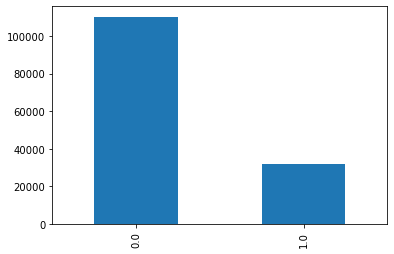

In [7]:
#Mirar si el dataset esta balanceado o no
df['RainTomorrow'].value_counts().plot.bar();

In [8]:
#Oversampling o undersampling?

In [9]:
from sklearn.utils import resample

#Oversampling
no = df[df.RainTomorrow == 0]
yes = df[df.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=42)
oversampled = pd.concat([no, yes_oversampled])

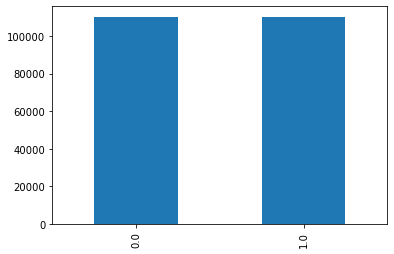

In [10]:
oversampled['RainTomorrow'].value_counts().plot.bar();

In [11]:
from sklearn.utils import resample

#undersampling
no = df[df.RainTomorrow == 0]
yes = df[df.RainTomorrow == 1]
no_undersampled = resample(no, replace=True, n_samples=len(yes), random_state=42)
undersampled = pd.concat([yes, no_undersampled])

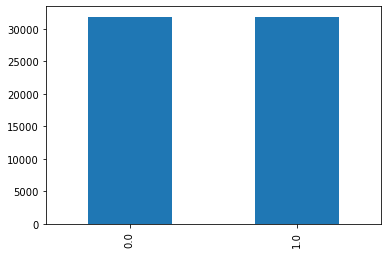

In [12]:
undersampled['RainTomorrow'].value_counts().plot.bar();

In [13]:
#Trabajamos con el undersampled, tratamiento de los missings

In [14]:
def data_report(df):
    # Sacamos los NOMBRES
    cols = pd.DataFrame(df.columns.values, columns=["COL_N"])

    # Sacamos los TIPOS
    types = pd.DataFrame(df.dtypes.values, columns=["DATA_TYPE"])

    # Sacamos los MISSINGS
    percent_missing = round(df.isnull().sum() * 100 / len(df), 2)
    percent_missing_df = pd.DataFrame(percent_missing.values, columns=["MISSINGS (%)"])

    # Sacamos los VALORES UNICOS
    unicos = pd.DataFrame(df.nunique().values, columns=["UNIQUE_VALUES"])
    
    percent_cardin = round(unicos['UNIQUE_VALUES']*100/len(df), 2)
    percent_cardin_df = pd.DataFrame(percent_cardin.values, columns=["CARDIN (%)"])

    concatenado = pd.concat([cols, types, percent_missing_df, unicos, percent_cardin_df], axis=1, sort=False)
    concatenado.set_index('COL_N', drop=True, inplace=True)


    return concatenado.T
        
data_report(undersampled)

COL_N,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
DATA_TYPE,object,object,float64,float64,float64,float64,float64,object,float64,object,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
MISSINGS (%),0.0,0.0,0.49,0.21,1.41,43.19,47.35,7.11,7.06,6.58,...,1.4,2.71,9.7,9.71,36.83,38.7,0.72,2.05,1.41,0.0
UNIQUE_VALUES,3325,49,376,484,629,273,144,16,66,16,...,99,101,532,532,9,9,418,484,2,2
CARDIN (%),5.22,0.08,0.59,0.76,0.99,0.43,0.23,0.03,0.1,0.03,...,0.16,0.16,0.83,0.83,0.01,0.01,0.66,0.76,0.0,0.0


In [15]:
undersampled.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday        float64
RainTomorrow     float64
dtype: object

In [16]:
#Rellenado los missings categoricos con la moda
undersampled['Date'] = undersampled['Date'].fillna(undersampled['Date'].mode()[0])
undersampled['Location'] = undersampled['Location'].fillna(undersampled['Location'].mode()[0])
undersampled['WindGustDir'] = undersampled['WindGustDir'].fillna(undersampled['WindGustDir'].mode()[0])
undersampled['WindDir9am'] = undersampled['WindDir9am'].fillna(undersampled['WindDir9am'].mode()[0])
undersampled['WindDir3pm'] = undersampled['WindDir3pm'].fillna(undersampled['WindDir3pm'].mode()[0])

# Convertir los categoricos con laber encoder

from sklearn import preprocessing
lencoders = {}
for col in undersampled.select_dtypes(include=['object']).columns:
    lencoders[col] = preprocessing.LabelEncoder()
    undersampled[col] = lencoders[col].fit_transform(undersampled[col])
    

In [17]:
undersampled.dtypes

Date               int32
Location           int32
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir        int32
WindGustSpeed    float64
WindDir9am         int32
WindDir3pm         int32
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday        float64
RainTomorrow     float64
dtype: object

In [18]:
#Variables numericas se van a rellenar con la media, el KNN imputer tardaba muchisimo
undersampled['MinTemp'] = undersampled['MinTemp'].fillna(undersampled['MinTemp'].mean())
undersampled['MaxTemp'] = undersampled['MaxTemp'].fillna(undersampled['MaxTemp'].mean())
undersampled['Rainfall'] = undersampled['Rainfall'].fillna(undersampled['Rainfall'].mean())
undersampled['Evaporation'] = undersampled['Evaporation'].fillna(undersampled['Evaporation'].mean())
undersampled['Sunshine'] = undersampled['Sunshine'].fillna(undersampled['Sunshine'].mean())
undersampled['WindGustSpeed'] = undersampled['WindGustSpeed'].fillna(undersampled['WindGustSpeed'].mean())
undersampled['WindSpeed9am'] = undersampled['WindSpeed9am'].fillna(undersampled['WindSpeed9am'].mean())
undersampled['WindSpeed3pm'] = undersampled['WindSpeed3pm'].fillna(undersampled['WindSpeed3pm'].mean())
undersampled['Humidity9am'] = undersampled['Humidity9am'].fillna(undersampled['Humidity9am'].mean())
undersampled['Humidity3pm'] = undersampled['Humidity3pm'].fillna(undersampled['Humidity3pm'].mean())
undersampled['Pressure9am'] = undersampled['Pressure9am'].fillna(undersampled['Pressure9am'].mean())
undersampled['Pressure3pm'] = undersampled['Pressure3pm'].fillna(undersampled['Pressure3pm'].mean())
undersampled['Cloud9am'] = undersampled['Cloud9am'].fillna(undersampled['Cloud9am'].mean())
undersampled['Cloud3pm'] = undersampled['Cloud3pm'].fillna(undersampled['Cloud3pm'].mean())
undersampled['Temp9am'] = undersampled['Temp9am'].fillna(undersampled['Temp9am'].mean())
undersampled['Temp3pm'] = undersampled['Temp3pm'].fillna(undersampled['Temp3pm'].mean())
undersampled['RainToday'] = undersampled['RainToday'].fillna(undersampled['RainToday'].mean())

In [19]:
data_report(undersampled)

COL_N,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
DATA_TYPE,int32,int32,float64,float64,float64,float64,float64,int32,float64,int32,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UNIQUE_VALUES,3325,49,377,485,630,274,145,16,67,16,...,100,102,533,533,10,10,419,485,3,2
CARDIN (%),5.22,0.08,0.59,0.76,0.99,0.43,0.23,0.03,0.11,0.03,...,0.16,0.16,0.84,0.84,0.02,0.02,0.66,0.76,0.0,0.0


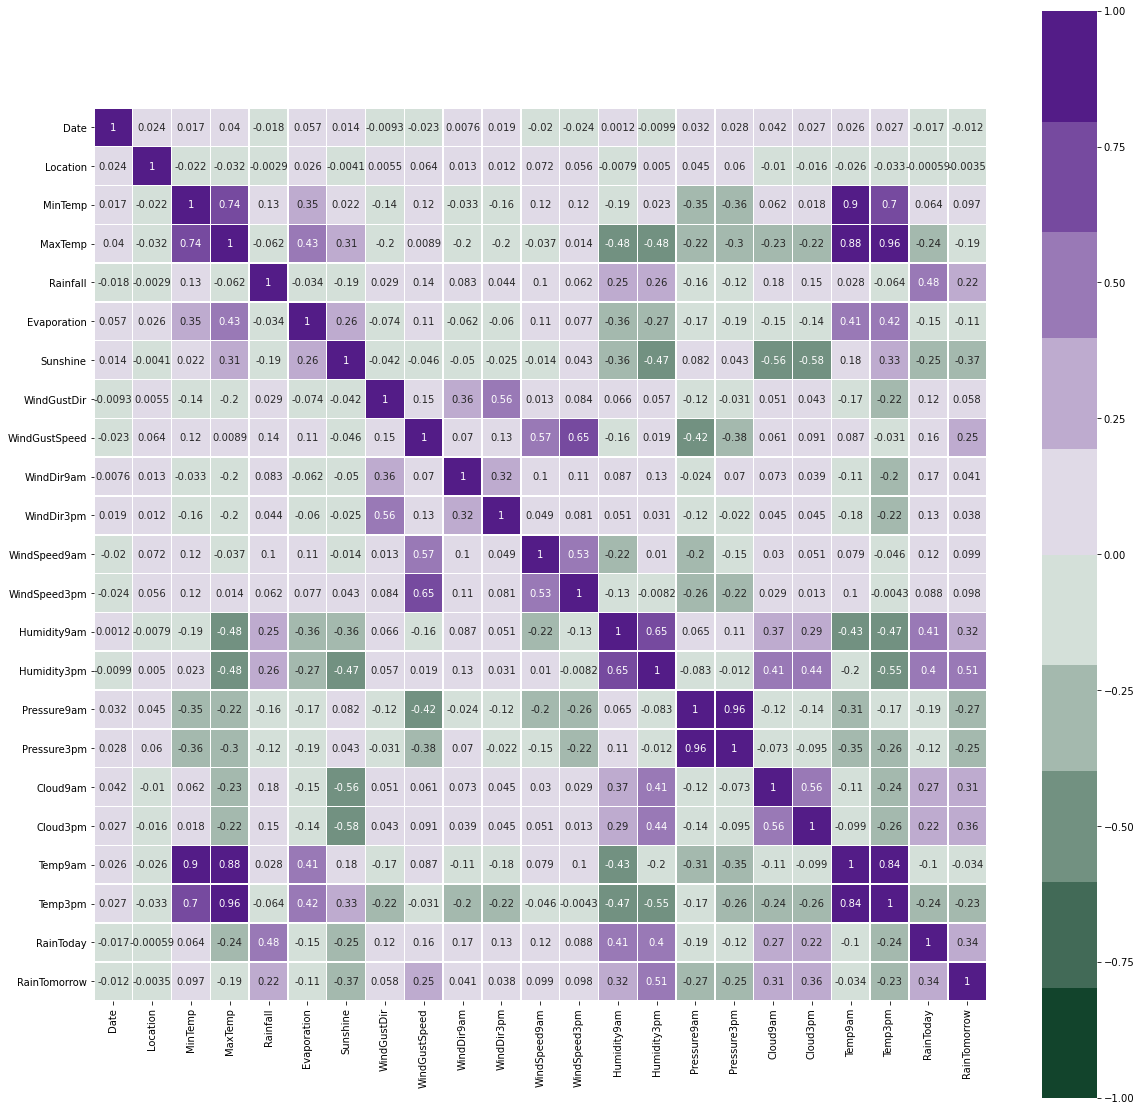

In [20]:
#Matriz para ver las correlaciones
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,20))
sns.heatmap(undersampled.corr(),
            vmin=-1,
            vmax=1,
            center=0,
            cmap=sns.diverging_palette(145, 280, s=85, l=25, n=10),
            square=True,
            annot=True,
            linewidths=.5);

In [21]:
undersampled

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
8,293,2,9.7,31.9,0.0,5.118528,6.499398,6,80.000000,9,...,42.0,9.0,1008.900000,1003.600000,5.054208,5.201914,18.3,30.2,0.0,1.0
10,295,2,13.4,30.4,0.0,5.118528,6.499398,3,30.000000,10,...,48.0,22.0,1011.800000,1008.700000,5.054208,5.201914,20.4,28.8,0.0,1.0
11,296,2,15.9,21.7,2.2,5.118528,6.499398,5,31.000000,4,...,89.0,91.0,1010.500000,1004.200000,8.000000,8.000000,15.9,17.0,1.0,1.0
12,297,2,15.9,18.6,15.6,5.118528,6.499398,13,61.000000,6,...,76.0,93.0,994.300000,993.000000,8.000000,8.000000,17.4,15.8,1.0,1.0
16,301,2,14.1,20.9,0.0,5.118528,6.499398,1,22.000000,11,...,69.0,82.0,1012.200000,1010.400000,8.000000,1.000000,17.2,18.1,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60159,2302,6,2.6,18.8,0.0,5.118528,6.499398,5,37.000000,4,...,67.0,47.0,1030.000000,1025.300000,5.054208,2.000000,12.4,17.9,0.0,0.0
15324,533,24,4.4,19.8,0.0,5.118528,6.499398,13,42.135126,3,...,79.0,38.0,1016.479745,1014.191272,1.000000,2.000000,10.2,19.0,0.0,0.0
75518,854,33,2.2,13.6,0.0,1.000000,1.600000,5,24.000000,5,...,100.0,84.0,1032.600000,1028.700000,8.000000,8.000000,6.1,13.1,0.0,0.0
130592,886,15,1.4,13.8,0.4,0.400000,6.800000,6,54.000000,5,...,83.0,43.0,1027.100000,1023.300000,1.000000,7.000000,4.2,11.8,0.0,0.0


In [22]:
#separado de features y del target
features = undersampled[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 
                       'RainToday']]
target = undersampled['RainTomorrow']

In [23]:
#train y test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

In [24]:
# escalado de las features
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.fit_transform(X_test)

In [25]:
#Random forest
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

t0=time.time()
rnd_clf = RandomForestClassifier(n_estimators = 250,
                                random_state = 42)

rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
tt_rf = time.time()-t0

print('Accuracy: ', accuracy_rf, 'Tiempo: ', tt_rf)

Accuracy:  0.8207199435338405 Tiempo:  16.95549774169922


In [26]:
#XG_boost
import xgboost
xgb_clas = xgboost.XGBClassifier(random_state=42)

t0=time.time()
xgb_clas.fit(X_train, y_train)
y_pred_xgb = xgb_clas.predict(X_test)
accuracy_xg = accuracy_score(y_test, y_pred_xgb)
tt_xg = time.time()-t0

print('Accuracy: ', accuracy_xg, 'Tiempo: ', tt_xg)

[18:27:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\angel\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy:  0.8051917496666928 Tiempo:  1.4033019542694092


In [27]:
#Logistic regression
from sklearn.linear_model import LogisticRegression

t0=time.time()
lr_clas = LogisticRegression(penalty= 'l1', solver= 'liblinear', random_state=42)
lr_clas.fit(X_train, y_train)
y_pred_lr = lr_clas.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
tt_lr = time.time()-t0

print('Accuracy: ', accuracy_lr, 'Tiempo: ', tt_lr)

Accuracy:  0.7786055995608188 Tiempo:  0.41959714889526367


In [28]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
import time

t0=time.time()
tree_clas = DecisionTreeClassifier(max_depth= 16,
             max_features= "sqrt")

tree_clas.fit(X_train, y_train)
y_pred_tree = tree_clas.predict(X_test)
accuracy_tree = accuracy_score(y_test, y_pred_tree)
tt_tree = time.time()-t0

print('Accuracy: ', accuracy_tree, 'Tiempo: ', tt_tree)

Accuracy:  0.752411575562701 Tiempo:  0.12462902069091797


In [29]:
accuracy_scores = [accuracy_lr, accuracy_xg, accuracy_rf, accuracy_tree]
print(accuracy_scores)

tt = [tt_lr, tt_xg, tt_rf, tt_tree]
print(tt)

[0.7786055995608188, 0.8051917496666928, 0.8207199435338405, 0.752411575562701]
[0.41959714889526367, 1.4033019542694092, 16.95549774169922, 0.12462902069091797]


In [31]:
model_data = {'Model': ['Logistic Regression', 'XGBoost', 'Random Forest', 'Decision Tree'],
              'Accuracy': accuracy_scores,
              'Time taken': tt}

data = pd.DataFrame(model_data)
data

,Model,Accuracy,Time taken
0,Logistic Regression,0.778606,0.419597
1,XGBoost,0.805192,1.403302
2,Random Forest,0.820720,16.955498
3,Decision Tree,0.752412,0.124629


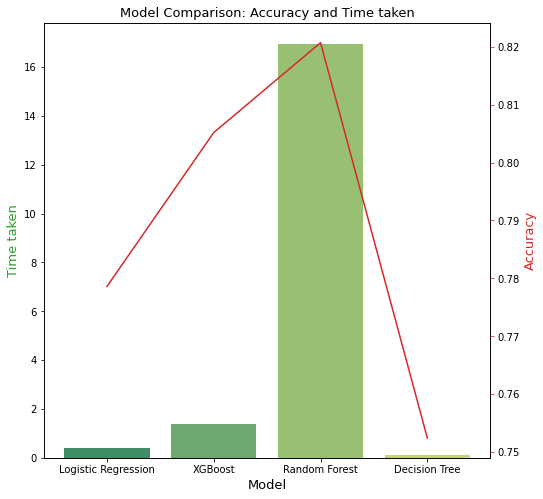

In [32]:
fig, ax1 = plt.subplots(figsize=(8,8))
ax1.set_title('Model Comparison: Accuracy and Time taken', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('Time taken', fontsize=13, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = data, palette='summer')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', fontsize=13, color=color)
ax2 = sns.lineplot(x='Model', y='Accuracy', data = data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

[[5354 1069]
 [1217 5111]]


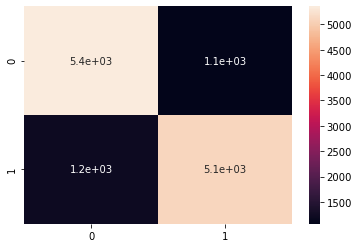

In [37]:
c_matrix = confusion_matrix(y_test, y_pred_rf)
print(c_matrix)

sns.heatmap(c_matrix, annot=True);

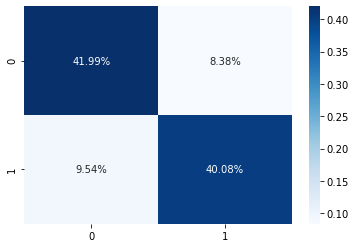

In [40]:
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, 
            fmt='.2%', cmap='Blues');